In [1]:
import numpy as np
import sys
from pathlib import Path

# Add the parent directory of the notebook to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.load import load_feature_matrices, load_metadata
from scripts.features import save_ctms, save_sequences
from utils.frobenius import create_frobenius_adjacency_matrix, create_masked_cosine_adjacency
from models.graph import create_movie_nodes, MovieGraph

In [2]:
save_sequences("../data/midis", "../data/sequences")
save_ctms("../data/midis", "../data/ctms")

Processing MIDIs: 0it [00:00, ?it/s]

Processing MIDIs: 16it [00:02,  7.91it/s]/home/jyanespu/project-02807/.venv/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing MIDIs: 88it [00:12,  7.05it/s]
2025-11-11 19:15:31.309 | SUCCESS  | scripts.features:save_sequences:127 - Processed 88 MIDI files -> saved to ../data/sequences/sequences_summary.csv
Processing MIDIs: 88it [00:13,  6.58it/s]
2025-11-11 19:15:44.694 | SUCCESS  | scripts.features:save_ctms:91 - Processed 88 MIDI files -> saved to ../data/ctms/summary.csv


In [3]:
matrices_df = load_feature_matrices("../data/ctms")
metadata_df = load_metadata("../data/metadata/movies_metadata.csv")

# Normalize each CTM so the total sum is 1
def normalize_rowwise(M: np.ndarray) -> np.ndarray:
    M = M.astype(np.float64)          # convert to float
    row_sums = M.sum(axis=1, keepdims=True)
    return np.divide(M, row_sums, out=np.zeros_like(M), where=row_sums!=0)

matrices_df['matrix'] = matrices_df['matrix'].apply(normalize_rowwise)

metadata_df = metadata_df.loc[matrices_df.index] # align matrices and metadata

Loading matrices: 92it [00:00, 1238.70it/s]
2025-11-11 19:15:44.839 | SUCCESS  | utils.load:load_feature_matrices:45 - Loaded 92 matrices from ../data/ctms


In [4]:
ctms_list = matrices_df['matrix'].tolist()
frob_matrix = create_masked_cosine_adjacency(ctms_list)

Computing masked cosine adjacency: 100%|██████████| 92/92 [00:00<00:00, 100.14it/s]


In [5]:
print(metadata_df.head())
nodes = create_movie_nodes(metadata_df)
graph = MovieGraph(nodes, frob_matrix)

                                     title     released  \
id                                                        
tt0026138            Bride of Frankenstein  06 May 1935   
tt0029583  Snow White and the Seven Dwarfs  04 Feb 1938   
tt0032138                 The Wizard of Oz  25 Aug 1939   
tt0040076           Adventures of Don Juan  29 Jan 1949   
tt0045152              Singin' in the Rain  10 Apr 1952   

                                                director  imdbrating  \
id                                                                     
tt0026138                                    James Whale         7.8   
tt0029583  William Cottrell, David Hand, Wilfred Jackson         7.6   
tt0032138    Victor Fleming, George Cukor, Norman Taurog         8.1   
tt0040076                                Vincent Sherman         7.0   
tt0045152                      Stanley Donen, Gene Kelly         8.3   

                                                     ratings  \
id               

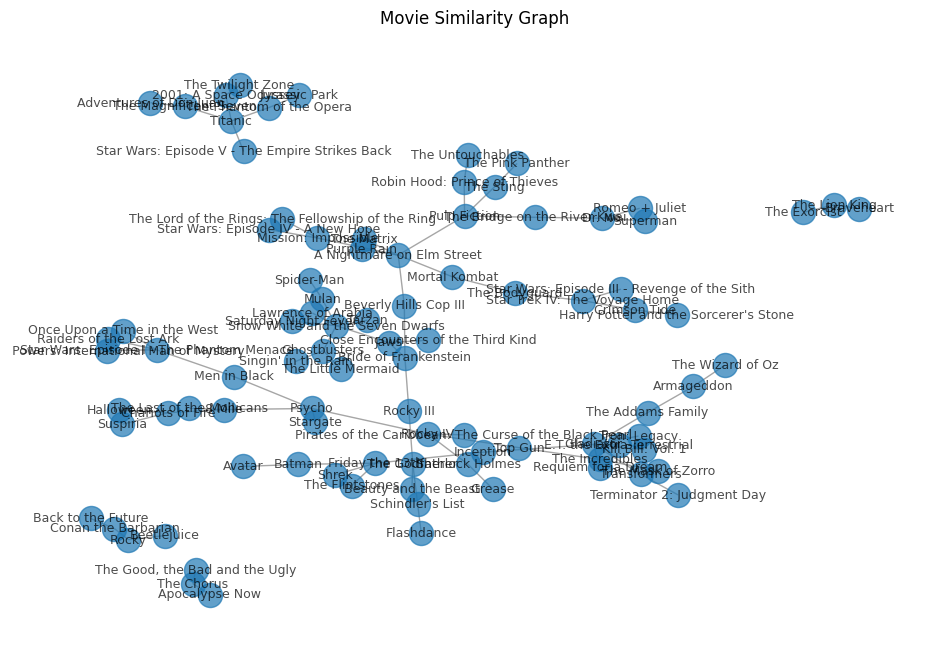

In [6]:
threshold = np.percentile(frob_matrix[np.triu_indices_from(frob_matrix, 1)], 75)
graph.plot_graph_networkx(frob_matrix, k=1, threshold=threshold, layout="spring")

**Recall:** For small $k$ (e.g. 2, 3), only the very closest neighbors are connected. Can create many disconnected components.

### Exploring the data

In [7]:
import numpy as np

def top_similar_movies_list(adjacency_matrix, nodes, top_k=10):
    """
    Returns a list of the top_k most similar movie pairs (shortest Frobenius distance).
    
    Args:
        adjacency_matrix (np.ndarray): Frobenius distance matrix.
        nodes (list): List of MovieNode objects.
        top_k (int): Number of top pairs to return.
    
    Returns:
        list of tuples: [(movie1_title, movie2_title, distance), ...]
    """
    n = adjacency_matrix.shape[0]
    triu_idx = np.triu_indices(n, k=1)  # upper triangle indices
    all_pairs = [(i, j, adjacency_matrix[i, j]) for i, j in zip(*triu_idx)]
    all_pairs.sort(key=lambda x: x[2], reverse=False)  # smallest distance = most similar
    top_pairs = all_pairs[:top_k]
    
    return [(nodes[i].title, nodes[j].title, dist) for i, j, dist in top_pairs]

# Usage example:
top_10 = top_similar_movies_list(frob_matrix, graph.nodes, top_k=10)
for m1, m2, dist in top_10:
    print(f"{m1} <-> {m2}: distance={dist:.2f}")


Star Wars: Episode V - The Empire Strikes Back <-> Star Wars: Episode III - Revenge of the Sith: distance=0.47
Adventures of Don Juan <-> Star Wars: Episode V - The Empire Strikes Back: distance=0.53
Star Wars: Episode V - The Empire Strikes Back <-> Harry Potter and the Sorcerer's Stone: distance=0.58
Star Wars: Episode III - Revenge of the Sith <-> Harry Potter and the Sorcerer's Stone: distance=0.61
Adventures of Don Juan <-> Star Wars: Episode III - Revenge of the Sith: distance=0.62
Adventures of Don Juan <-> Apocalypse Now: distance=0.62
Adventures of Don Juan <-> Harry Potter and the Sorcerer's Stone: distance=0.62
Star Wars: Episode V - The Empire Strikes Back <-> Romeo + Juliet: distance=0.62
Apocalypse Now <-> Star Wars: Episode V - The Empire Strikes Back: distance=0.65
Apocalypse Now <-> Harry Potter and the Sorcerer's Stone: distance=0.66


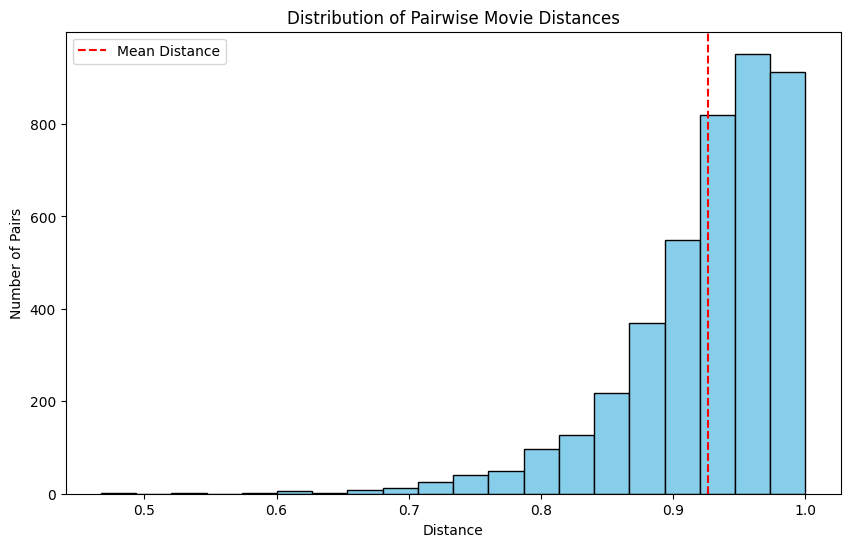

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Get upper triangle indices, excluding the diagonal
triu_idx = np.triu_indices(frob_matrix.shape[0], k=1)
all_distances = frob_matrix[triu_idx]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(all_distances, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Pairwise Movie Distances")
plt.xlabel("Distance")
plt.ylabel("Number of Pairs")
plt.axvline(np.mean(all_distances), color='red', linestyle='dashed', label='Mean Distance')
plt.legend()
plt.show()

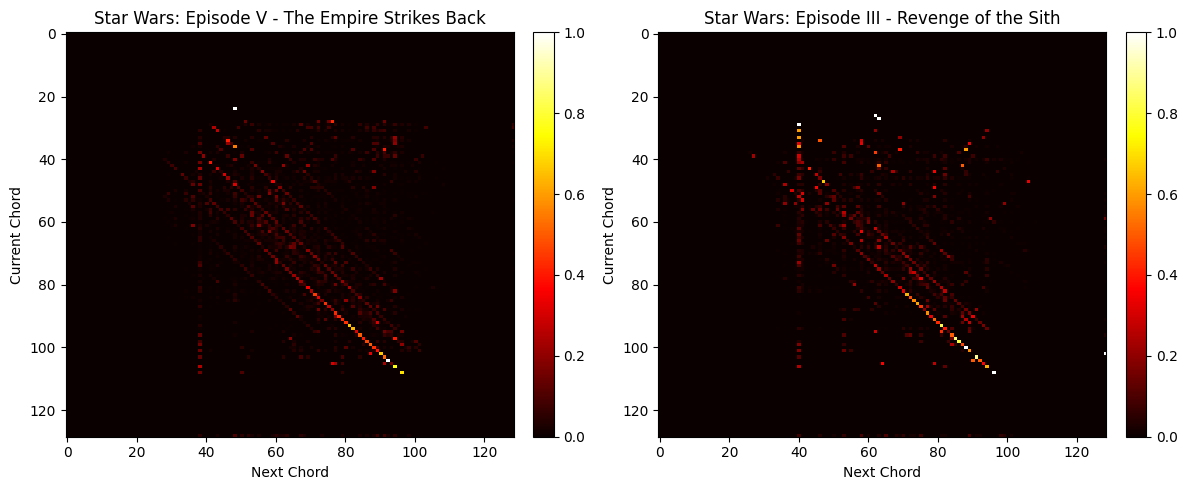

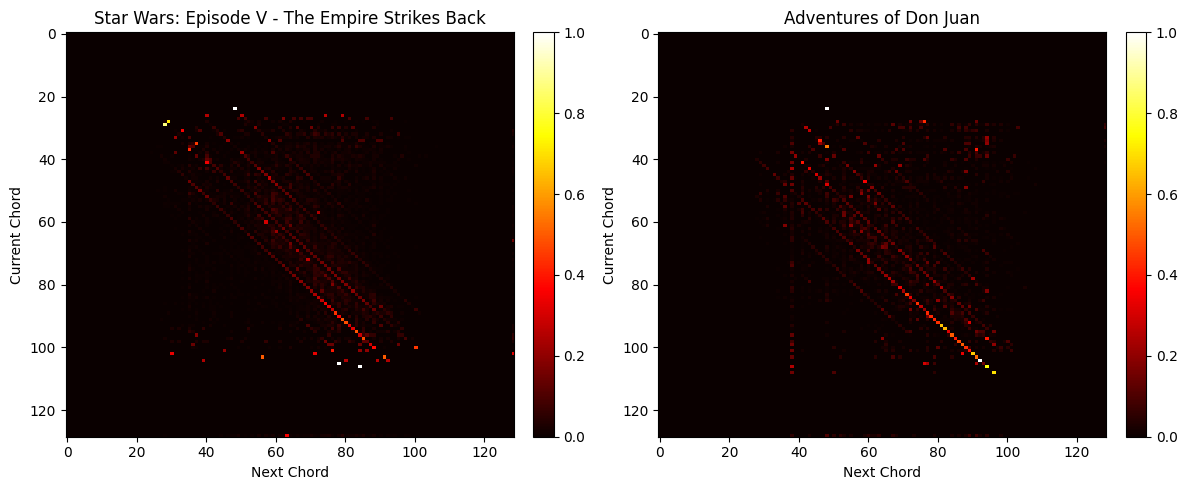

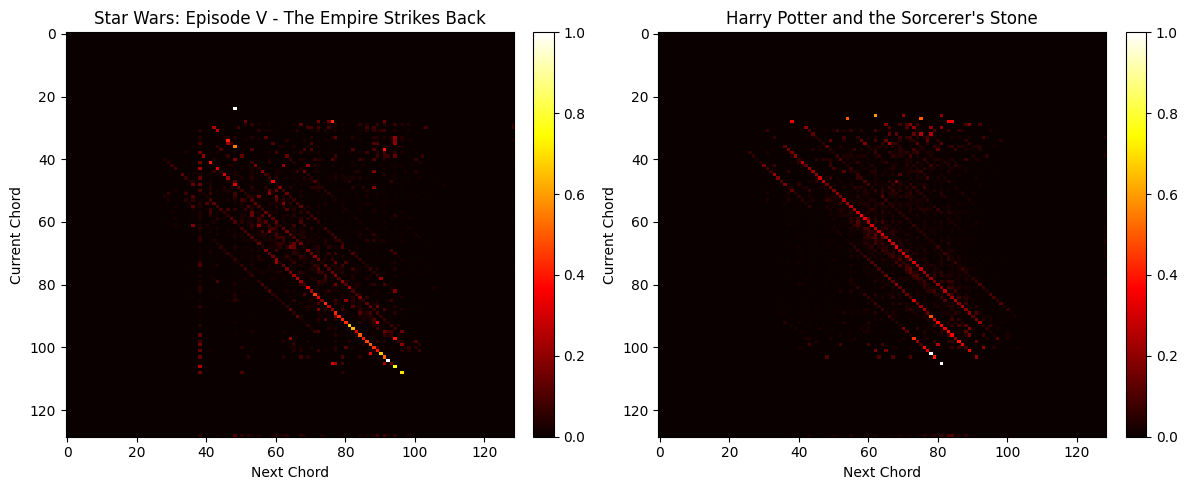

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ctms_side_by_side(matrices_df, metadata_df, titles=None, n_random=4):
    """
    Plot several CTMs side by side for visual comparison.
    
    Args:
        matrices_df (pd.DataFrame): DataFrame with 'matrix' column.
        metadata_df (pd.DataFrame): DataFrame with 'title' column matching matrices_df.
        titles (list[str] | None): List of movie titles to plot. If None, random movies are plotted.
        n_random (int): Number of random movies if titles is None.
    """
    if titles is None:
        random_indices = np.random.choice(matrices_df.shape[0], size=n_random, replace=False)
        matrices_to_plot = matrices_df.iloc[random_indices]
        titles = metadata_df.iloc[random_indices]['title'].tolist()
    else:
        matrices_to_plot = matrices_df.loc[metadata_df['title'].isin(titles)]

    n_plots = len(matrices_to_plot)
    n_cols = min(2, n_plots)
    n_rows = (n_plots + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = np.array(axes).reshape(-1)  # flatten in case of single row/col

    for ax, (_, row), title in zip(axes, matrices_to_plot.iterrows(), titles):
        matrix = row['matrix']
        im = ax.imshow(matrix, cmap='hot', aspect='auto', interpolation='nearest')
        ax.set_title(title)
        ax.set_xlabel("Next Chord")
        ax.set_ylabel("Current Chord")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # hide unused axes
    for ax in axes[n_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Compare two chosen movies
plot_ctms_side_by_side(matrices_df, metadata_df, titles=["Star Wars: Episode V - The Empire Strikes Back", "Star Wars: Episode III - Revenge of the Sith"])
plot_ctms_side_by_side(matrices_df, metadata_df, titles=["Star Wars: Episode V - The Empire Strikes Back", "Adventures of Don Juan"])
plot_ctms_side_by_side(matrices_df, metadata_df, titles=["Star Wars: Episode V - The Empire Strikes Back", "Harry Potter and the Sorcerer's Stone"])

## Spectral clustering

### Step 1: Distances to similarity

In [69]:
def distance_to_similarity(D: np.ndarray, sigma: float = None) -> np.ndarray:
    """
    Convert distance matrix D to similarity matrix S using a Gaussian kernel.
    """
    # Heuristic for sigma: median of non-zero distances
    if sigma is None:
        sigma = np.median(dist_matrix[D > 0]) / 2  # or even /3
        print(f"Using sigma = {sigma:.4f}")
    
    S = np.exp(-D**2 / (2 * sigma**2))
    np.fill_diagonal(S, 0)  # no self-similarity links
    return S

dist_matrix = create_masked_cosine_adjacency(ctms_list)
sim_matrix = distance_to_similarity(dist_matrix)

Computing masked cosine adjacency:   1%|          | 1/92 [00:00<00:14,  6.42it/s]

Computing masked cosine adjacency: 100%|██████████| 92/92 [00:07<00:00, 11.79it/s]


Using sigma = 0.4702


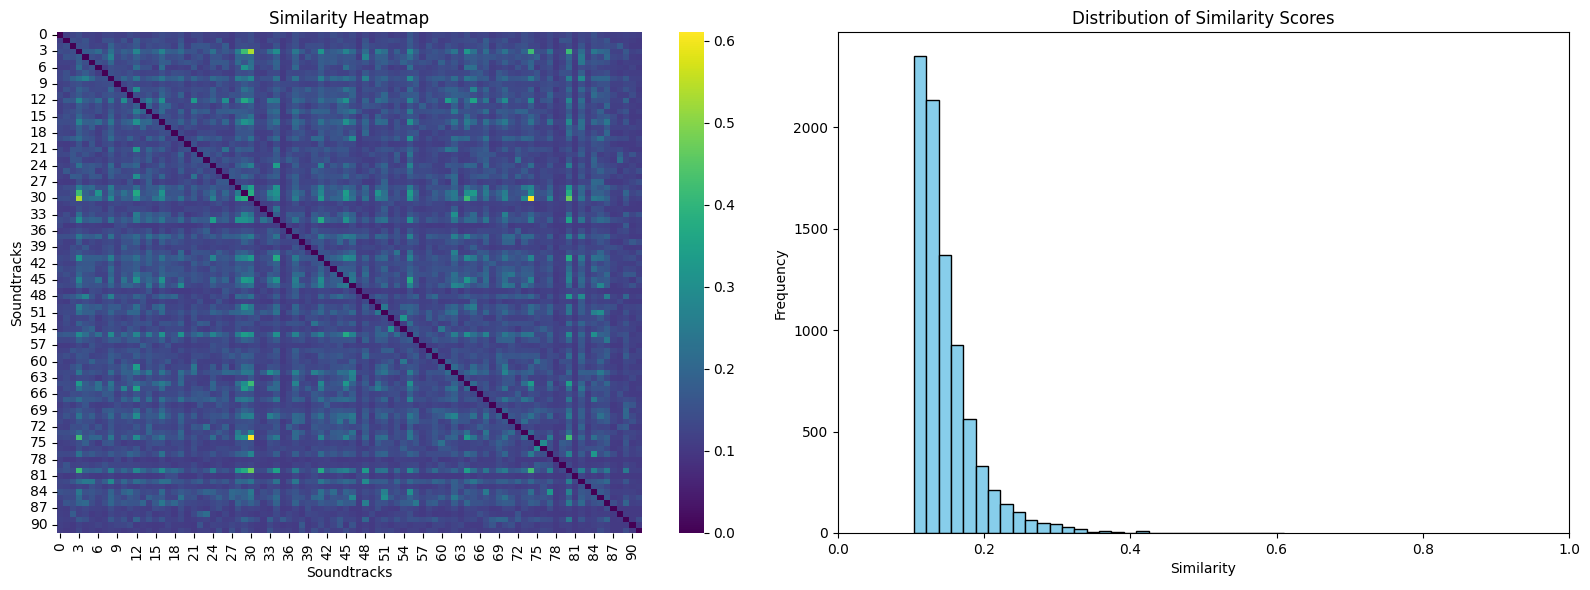

Mean similarity: 0.1472
Standard deviation: 0.0424


In [70]:
import seaborn as sns

sim_values = sim_matrix[~np.eye(sim_matrix.shape[0], dtype=bool)]

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(sim_matrix, cmap="viridis", ax=axes[0])
axes[0].set_title("Similarity Heatmap")
axes[0].set_xlabel("Soundtracks")
axes[0].set_ylabel("Soundtracks")

# Histogram
axes[1].hist(sim_values.flatten(), bins=30, color='skyblue', edgecolor='black')
axes[1].set_title("Distribution of Similarity Scores")
axes[1].set_xlabel("Similarity")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

mean_sim = np.mean(sim_values)
std_sim = np.std(sim_values)

print(f"Mean similarity: {mean_sim:.4f}")
print(f"Standard deviation: {std_sim:.4f}")

### Step 2: Compute the Laplacian

In [71]:
from scipy.linalg import fractional_matrix_power

D = np.diag(sim_matrix.sum(axis=1))
D_inv_sqrt = fractional_matrix_power(D, -0.5)
L_sym = np.eye(sim_matrix.shape[0]) - D_inv_sqrt @ sim_matrix @ D_inv_sqrt

### Step 3: Take the first $k$ eigenvectors

In [72]:
from scipy.linalg import eigh
from sklearn.preprocessing import normalize

k = 8  # desired number of clusters
eigvals, eigvecs = eigh(L_sym)

# Take the first k eigenvectors
X = eigvecs[:, :k]

X_norm = normalize(X, norm='l2', axis=1)

### Step 4: Run k-means on the eigenvectors

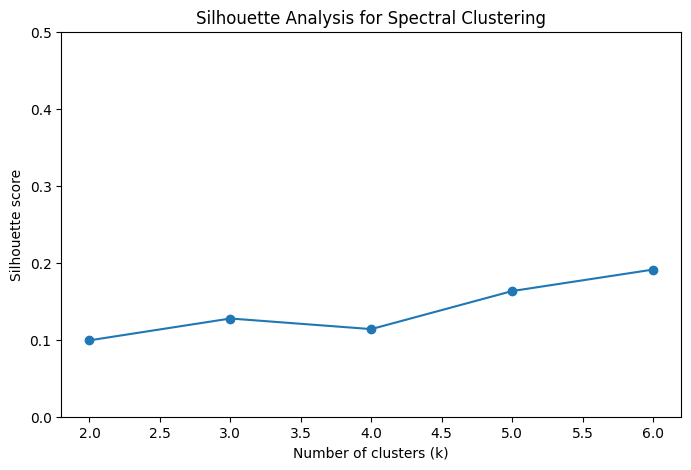

In [77]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 7)  # test from 2 to 6 clusters
scores = []
labels = kmeans.fit_predict(X_norm)  # X_norm from Laplacian step

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_norm)
    score = silhouette_score(X_norm, labels)
    scores.append(score)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.ylim(0, 0.5)
plt.title("Silhouette Analysis for Spectral Clustering")
plt.show()

In [78]:
kmeans = KMeans(n_clusters=k, random_state=42)

metadata_df['cluster'] = labels
matrices_df['cluster'] = labels

score = silhouette_score(X_norm, labels)
print(f"Silhouette score for k={k}: {score:.4f}")

Silhouette score for k=6: 0.1911


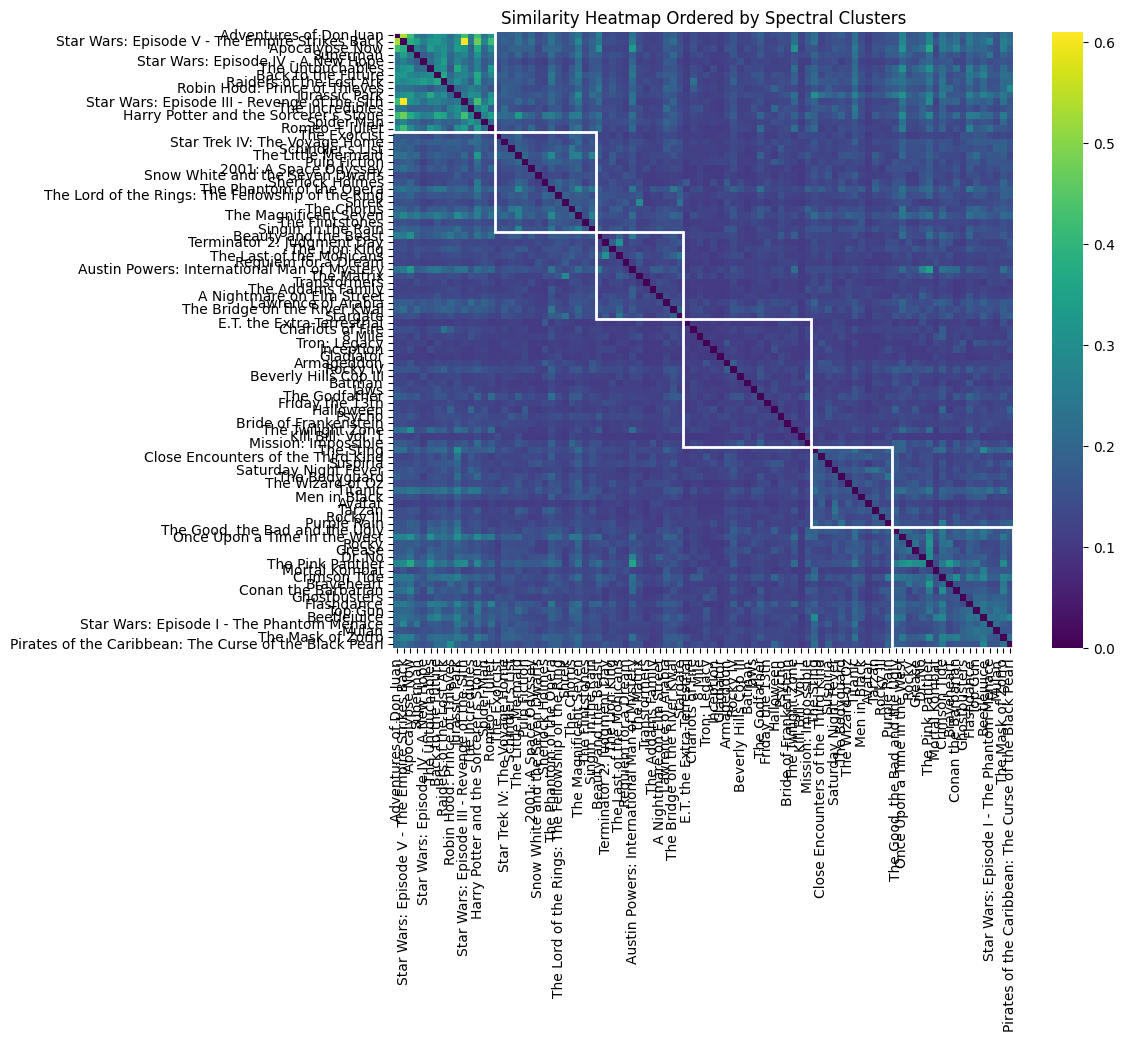

In [79]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Order indices by cluster
order = np.argsort(labels)
sim_ordered = sim_matrix[np.ix_(order, order)]
titles_ordered = metadata_df['title'].iloc[order].to_list()
labels_ordered = labels[order]

# Identify cluster boundaries
boundaries = [0]  # start index
current_label = labels_ordered[0]
for i, label in enumerate(labels_ordered):
    if label != current_label:
        boundaries.append(i)
        current_label = label
boundaries.append(len(labels_ordered))  # end index

# Plot heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(sim_ordered, xticklabels=titles_ordered, yticklabels=titles_ordered, cmap="viridis")
plt.title("Similarity Heatmap Ordered by Spectral Clusters")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Add boxes along the diagonal for each cluster
for i in range(len(boundaries)-1):
    start = boundaries[i]
    end = boundaries[i+1]
    width = end - start
    rect = Rectangle((start, start), width, width, fill=False, edgecolor='white', linewidth=2)
    ax.add_patch(rect)

plt.show()

In [80]:
for cluster_id in range(k):
    print(f"\nCluster {cluster_id}:")
    print(metadata_df[metadata_df['cluster'] == cluster_id]['title'].values)


Cluster 0:
['Adventures of Don Juan' 'Star Wars: Episode IV - A New Hope' 'Superman'
 'Apocalypse Now' 'Star Wars: Episode V - The Empire Strikes Back'
 'Raiders of the Lost Ark' 'Back to the Future' 'The Untouchables'
 'Robin Hood: Prince of Thieves' 'Jurassic Park' 'Romeo + Juliet'
 'Star Wars: Episode III - Revenge of the Sith' 'Spider-Man'
 "Harry Potter and the Sorcerer's Stone" 'The Incredibles']

Cluster 1:
['Snow White and the Seven Dwarfs' "Singin' in the Rain" 'The Flintstones'
 'The Magnificent Seven' '2001: A Space Odyssey' 'The Exorcist'
 'Star Trek IV: The Voyage Home' 'The Little Mermaid' "Schindler's List"
 'Pulp Fiction' 'The Lord of the Rings: The Fellowship of the Ring'
 'Shrek' 'The Phantom of the Opera' 'The Chorus' 'Sherlock Holmes']

Cluster 2:
['The Bridge on the River Kwai' 'Lawrence of Arabia'
 'A Nightmare on Elm Street' 'The Addams Family' 'Beauty and the Beast'
 'Terminator 2: Judgment Day' 'The Last of the Mohicans' 'The Lion King'
 'Stargate' 'Austin Pow